In [71]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import spconv.pytorch as spconv
import matplotlib.pyplot as plt
import mytools
import mymodels

# Load testing data

In [72]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [111]:
########################################
########################################
# Select Energy (35 or 50 keV)
Energy = 40
# Select diff amount (H or L)
Diff = 'H'
########################################
########################################


In [112]:
# Read pandas dataframe with all information about sparse testing tensors
st_info = pd.read_pickle('/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/sparse_tensor_info.pk')
st_info.head()

,dir,offset,diff,energy
0,"[-0.9059989412649654, 0.3330733023117732, 0.26...","[1.8266272569888846, 0.22442560910839052, 0.04...",0.0443,40
1,"[-0.5710866775397127, -0.7536025709761512, -0....","[2.3028388182049855, 2.4187447290252235, -0.04...",0.0443,40
2,"[0.4480694627678147, 0.21285006921436286, -0.8...","[1.352839218771808, 0.7031124760262129, 1.0990...",0.0443,40
3,"[0.4873337835403693, 0.8520189791227151, 0.191...","[-1.6915320848865154, -1.5220214317304208, -1....",0.0443,40
4,"[0.15061381983445352, 0.7777885525240438, 0.61...","[-0.7984063441458031, -0.6732262537600343, 1.2...",0.0443,40


In [113]:
# Make custom dataset
MyDataset = mytools.CustomDataset(dir_loc='/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/', st_info=st_info)

# Create DataLoader
batch_size = 64
test_dataloader = DataLoader(MyDataset, batch_size=batch_size, shuffle=True)

# Print tensor shapes
for X_plot, y_plot, offset_plot in test_dataloader:
    print(f"Shape of X [N, C, H, W, D]: {X_plot.shape}")
    print(f"Shape of y: {y_plot.shape} {y_plot.dtype}")
    print("Offsets: ", offset_plot.shape)
    break
    
#Record shape of voxel grid
grid_shape = X_plot.shape[1:4]
print("Voxel grid shape: " , grid_shape)


Shape of X [N, C, H, W, D]: torch.Size([64, 120, 120, 120, 1])
Shape of y: torch.Size([64, 3]) torch.float32
Offsets:  torch.Size([64, 3])
Voxel grid shape:  torch.Size([120, 120, 120])


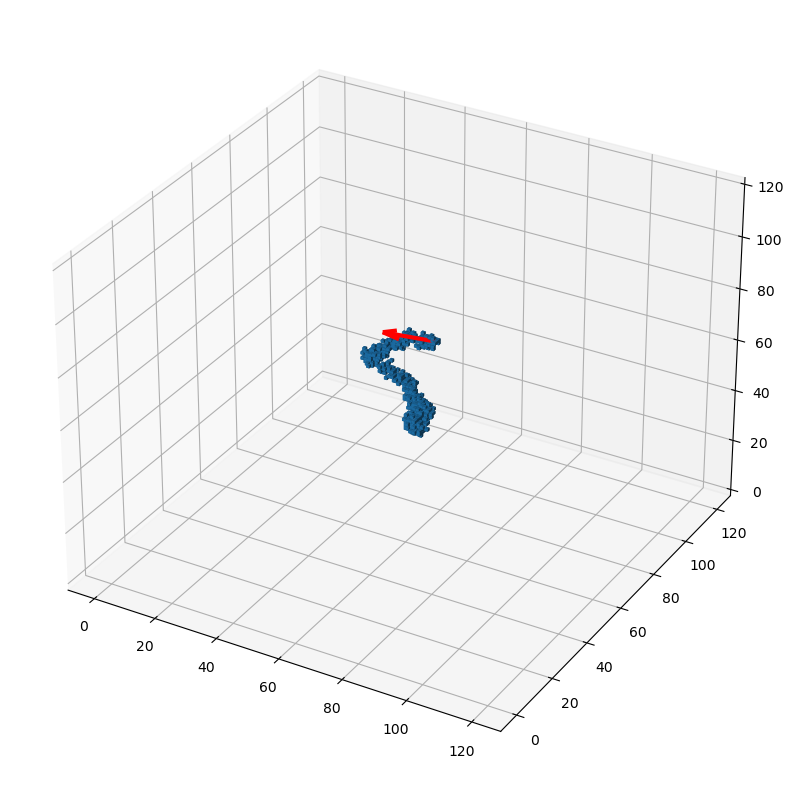

In [114]:
# Plot an example as a sanity check

# x/y/z length being kept in cm
eff_l = mytools.voxel_grid['eff_l']
# Voxel size in cm
vox_l = mytools.voxel_grid['vox_l']

#Convert to dense, reshape and convert to numpy
X_plot = X_plot.to_dense().reshape(-1, 1, 120, 120, 120).numpy()

index = 2
mytools.plot_tensor_dir(tensor = X_plot[index], start = offset_plot[index].numpy(), direction = y_plot[index].numpy(), eff_l=eff_l, vox_l=vox_l)



# Test HSCDC CNN Model

In [115]:
# Load the model
model_HSCDC = torch.load('../3D_Heteroscedastic_Convnet_models/3D_HSCDC_CNN_spconv.pt').to(device)

# Obtain predictions and Labels
v_pred_HSCDC, K_pred_HSCDC, v_true_HSCDC, off_true_HSCDC = mytools.test_HSCDC(test_dataloader,model_HSCDC,device)

In [116]:
# Compute the cosine similarity loss using the mean predictions from the HSCDC model
HSCDC_Loss = mytools.CSloss(v_pred_HSCDC, v_true_HSCDC)
HSCDC_Loss

tensor(-0.8504)

In [117]:
# Now compute the Loss versus efficiency cuts in K_pred (the uncertainty prediction in the HSCDC model)

# Percent of data that is cut
eff = np.arange(0,90,1)
# Coresponding percentiles
pers = np.percentile(K_pred_HSCDC,eff)

# Compute loss at each percentile
eff_loss = []
for per in pers:
    
    T_vals = (K_pred_HSCDC >= per).flatten()
    v_pred_cut = v_pred_HSCDC[T_vals]
    v_true_cut = v_true_HSCDC[T_vals] 
    
    eff_loss += [mytools.CSloss(v_pred_cut, v_true_cut)]

    

Text(0, 0.5, 'Cosine Similairity Loss')

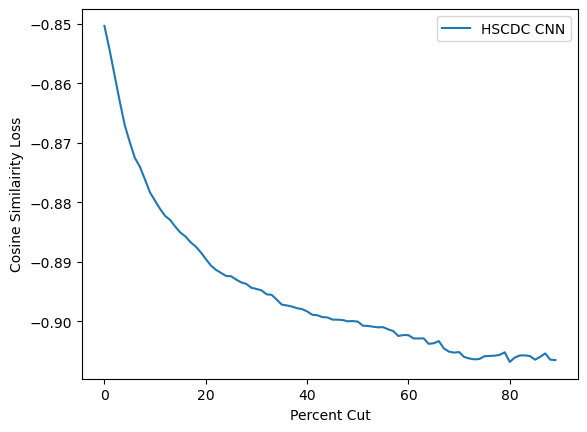

In [118]:
plt.plot(eff,eff_loss, label = "HSCDC CNN")
plt.legend()
plt.xlabel("Percent Cut")
plt.ylabel("Cosine Similairity Loss")

# Test Regular CNN Model

In [119]:
# Load the regular CNN model
model_CNN = torch.load('../3D_Heteroscedastic_Convnet_models/3D_CNN_spconv.pt').to(device)
# Obtain predictions and labels
v_pred_CNN, v_true_CNN, off_true_CNN = mytools.test_CNN(test_dataloader,model_CNN,device)

In [120]:
# Compute the cosine similairity loss, we cannot make efficiency cuts here
CNN_Loss = mytools.CSloss(v_pred_CNN, v_true_CNN)
CNN_Loss

tensor(-0.8567)

Text(0, 0.5, 'Cosine Similairity Loss')

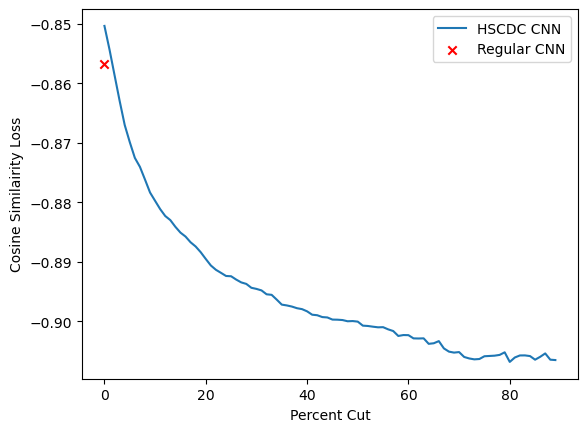

In [121]:
plt.plot(eff,eff_loss, label = "HSCDC CNN")
plt.scatter([0],[CNN_Loss], marker="x", color = 'r', label = "Regular CNN")
plt.legend()
plt.xlabel("Percent Cut")
plt.ylabel("Cosine Similairity Loss")

# Test Non-ML algorithim

In [122]:
# Load the non-ML model
model_NML = mymodels.NML

# x/y/z length being kept in cm
eff_l= mytools.voxel_grid['eff_l']
# Voxel size in cm
vox_l = mytools.voxel_grid['vox_l']

In [123]:
# Copy sparse tensor info dataframe
NML_info = st_info.copy()
# Promote index to column
NML_info = NML_info.reset_index()

# Add position and charge information for each row
NML_info["positions"] = NML_info.apply(lambda row: torch.load('/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/'+ 'sparse_recoils_' + str(row['index']) + '.pt').type(torch.FloatTensor).coalesce().indices().int().numpy()*vox_l-eff_l, axis=1)
NML_info["charges"] = NML_info.apply(lambda row: torch.load('/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/'+ 'sparse_recoils_' + str(row['index']) + '.pt').type(torch.FloatTensor).coalesce().values().flatten().numpy()*1.0, axis=1)

NML_info.head()

,index,dir,offset,diff,energy,positions,charges
0,0,"[-0.9059989412649654, 0.3330733023117732, 0.26...","[1.8266272569888846, 0.22442560910839052, 0.04...",0.0443,40,"[[-0.5499999999999998, -0.5, -0.5, -0.5, -0.5,...","[1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, ..."
1,1,"[-0.5710866775397127, -0.7536025709761512, -0....","[2.3028388182049855, 2.4187447290252235, -0.04...",0.0443,40,"[[-0.9499999999999997, -0.9499999999999997, -0...","[1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 3.0, 1.0, 2.0, ..."
2,2,"[0.4480694627678147, 0.21285006921436286, -0.8...","[1.352839218771808, 0.7031124760262129, 1.0990...",0.0443,40,"[[-0.5999999999999996, -0.5999999999999996, -0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ..."
3,3,"[0.4873337835403693, 0.8520189791227151, 0.191...","[-1.6915320848865154, -1.5220214317304208, -1....",0.0443,40,"[[-1.75, -1.75, -1.75, -1.75, -1.75, -1.7, -1....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, ..."
4,4,"[0.15061381983445352, 0.7777885525240438, 0.61...","[-0.7984063441458031, -0.6732262537600343, 1.2...",0.0443,40,"[[-0.8500000000000001, -0.8500000000000001, -0...","[1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


## Test NML model with standard parameters and without cheating

In [124]:
# Get true and predicted directions
v_pred_NML, v_true_NML, off_true_NML = mytools.test_NML(NML_info, model_NML, cheat=False)

#Compute efficiency and Loss
# In this method, an efficency cut must be made as SVD can fail if it is not given >= 2 points
NML_eff = len(v_pred_NML)/len(NML_info)
NML_Loss = mytools.CSloss(torch.Tensor(v_pred_NML), torch.Tensor(v_true_NML))
    
print(NML_Loss, NML_eff)

tensor(-0.4575) 0.986835493920209


## Test NML model with standard parameters and with cheating

In [125]:
# Get true and predicted directions
v_pred_NML_cheat, v_true_NML_cheat, off_true_NML_cheat = mytools.test_NML(NML_info, model_NML, cheat=True)

#Compute efficiency and Loss
# In this method, an efficency cut must be made as SVD can fail if it is not given >= 2 points
NML_eff_cheat = len(v_pred_NML_cheat)/len(NML_info)
NML_Loss_cheat = mytools.CSloss(torch.Tensor(v_pred_NML_cheat), torch.Tensor(v_true_NML_cheat))
    
print(NML_Loss_cheat, NML_eff_cheat)

tensor(-0.6725) 0.986835493920209


## Test NML model with parameters tuned no the testing set

In [126]:
df_tuned_cheat = pd.read_pickle('../tune_NML/tune_NML_'+str(Energy)+'keV_'+Diff+'diff_cheat-'+str(True)+'.pk')
df_tuned = pd.read_pickle('../tune_NML/tune_NML_'+str(Energy)+'keV_'+Diff+'diff_cheat-'+str(False)+'.pk')

min_tuned_cheat = df_tuned_cheat[['Loss']].idxmin()
min_tuned = df_tuned[['Loss']].idxmin()



In [127]:
Loss_tuned_cheat = df_tuned_cheat.iloc[min_tuned_cheat].Loss.item()
Eff_tuned_cheat = df_tuned_cheat.iloc[min_tuned_cheat].eff.item()
Loss_tuned = df_tuned.iloc[min_tuned].Loss.item()
Eff_tuned = df_tuned.iloc[min_tuned].eff.item()

# Plot final result

Text(0, 0.5, 'Cosine Similairity Loss')

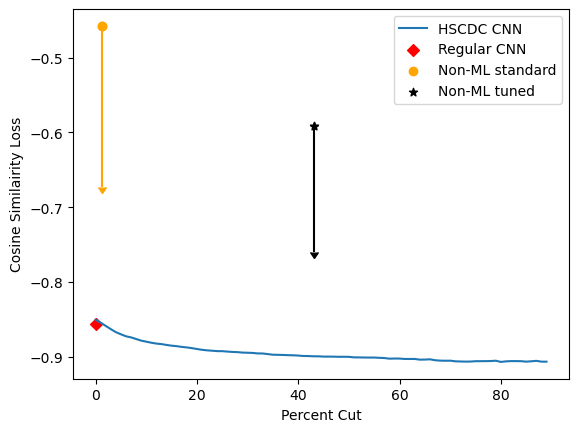

In [128]:
plt.plot(eff,eff_loss, label = "HSCDC CNN")
plt.scatter([0],[CNN_Loss], marker="D", color = 'r', label = "Regular CNN")

# Double plot as a has to format the legend properly
plt.scatter([100*(1-NML_eff)], [NML_Loss], marker='o', color = 'orange', label = "Non-ML standard")
plt.errorbar([100*(1-NML_eff)], [NML_Loss], yerr=[ np.abs(NML_Loss-NML_Loss_cheat) ], uplims=[1], fmt='o', color = 'orange')

# Double plot as a has to format the legend properly
plt.scatter([100*(1-Eff_tuned)], [Loss_tuned], marker='*', color = 'k', label = "Non-ML tuned")
plt.errorbar([100*(1-Eff_tuned)], [Loss_tuned], yerr=[ np.abs(Loss_tuned-Loss_tuned_cheat) ], uplims=[1], fmt='*', color = 'k')




plt.legend()
plt.xlabel("Percent Cut")
plt.ylabel("Cosine Similairity Loss")